In [1]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pylab as plt
import pandas as pd
from matplotlib.pylab import rcParams
from imblearn.combine import SMOTEENN
import collections
rcParams['figure.figsize'] = 12, 4

In [2]:
def confusio_matrix(y_test, y_predicted, text):
  cm = confusion_matrix(y_test, y_predicted)
  plt.figure(figsize=(15,10))
  plt.clf()
  plt.imshow(cm, interpolation='nearest')
  classNames = ['Negative','Positive']
  plt.title(f'Confusion Matrix - {text}')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames, rotation=45)
  plt.yticks(tick_marks, classNames)
  s = [['TN','FP'], ['FN', 'TP']]
  
  for i in range(2):
      for j in range(2):
          plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
  plt.show()
  TN = cm[0][0]
  FP = cm[0][1]
  FN = cm[1][0]
  TP = cm[1][1]
  return TN,FP,FN,TP

In [3]:
data_path = r"C:\Users\Lenovo\OneDrive - UGM 365\Documents\Second Brain\1 Projects\Skripsi\Code\Residential-Classification\Data Processing\labeled_building\Final_data.csv"
df = pd.read_csv(data_path, index_col=0)

validation_path = r'C:\Users\Lenovo\OneDrive - UGM 365\Documents\Second Brain\1 Projects\Skripsi\Code\Residential-Classification\Data Processing\labeled_building\validation\Final_data.csv'
validation_df = pd.read_csv(validation_path, index_col=0)

categorical_columns = df.select_dtypes(include=["object"]).columns.tolist()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_28224\324398234.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, index_col=0)


# 0. Check The Final Dataset
### Objective
1. Remove some incorrect data
2. Remove NaN rows
3. Reclassify some categorical data

## 0.a Removing Incorrect Data
#### Catatan
- Area >= 9m2 (at least 3x3m)
- Perimeter >= 12m2
- Closest street >= 1m

In [4]:
print('before :',len(df))
df = df[
    (df.b_area >= 9) &
    (df.b_perimeter >= 12) &
    (df.b_closest_street >= 0)
].copy()
print('after :',len(df))

print('before :',len(validation_df))
validation_df = validation_df[
    (validation_df.b_area >= 9) &
    (validation_df.b_perimeter >= 12) &
    (validation_df.b_closest_street >=0)
].copy()
print('before :',len(validation_df))

before : 361639
after : 360797
before : 27618
before : 27598


## 0.b Reclassify Categorical Values
- We drop irrelevant category
- Reclassify highway

In [5]:
categorical_columns.remove('highway')
categorical_columns.remove('building')
categorical_columns.remove('bID_kec')
df_dropped = df.drop(categorical_columns, axis=1).copy()
validation_df_dropped = validation_df.drop(categorical_columns, axis=1).copy()

In [6]:
# Reclass building
reclass_map = {
    'yes': 'yes',
    'sports_centre': 'non_residential',
    'apartments': 'residential',
    'hospital': 'non_residential',
    'mosque': 'non_residential',
    'school': 'non_residential',
    'government_office': 'non_residential',
    'clinic': 'non_residential',
    'industrial': 'non_residential',
    'office': 'non_residential',
    'village_office': 'non_residential',
    'church': 'non_residential',
    'power_substation': 'non_residential',
    'university': 'non_residential',
    'college': 'non_residential',
    'kindergarten': 'non_residential',
    'house': 'residential',
    'hotel': 'non_residential',
    'marketplace': 'non_residential',
    'community_group_office': 'non_residential',
    'subdistrict_office': 'non_residential',
    'residential': 'residential',
    'retail': 'non_residential',
    'commercial': 'non_residential',
    'garage': 'non_residential',
    'bank': 'non_residential',
    'detached': 'residential',
    'fire_station': 'non_residential',
    'supermarket': 'non_residential',
    'animal_boarding': 'non_residential',
    'police': 'non_residential',
    'roof': 'non_residential',
    'pumping_station': 'non_residential',
    'post_office': 'non_residential',
    'convenience': 'non_residential',
    'service': 'non_residential',
    'train_station': 'non_residential',
    'construction': 'non_residential',
    'library': 'non_residential',
    'parking': 'non_residential',
    'pharmacy': 'non_residential',
    'terrace': 'residential',
    'greengrocer': 'non_residential',
    'public': 'non_residential',
    'mall': 'non_residential',
    'government': 'non_residential',
    'transportation': 'non_residential',
    'civic': 'non_residential',
    'power_plant': 'non_residential',
    'temple': 'non_residential',
    'grandstand': 'non_residential',
    'warehouse': 'non_residential',
    'restaurant': 'non_residential',
    'embassy': 'non_residential',
    'institution': 'non_residential',
    'ruins': 'non_residential',
    'dormitory': 'residential',
    'social_facility': 'non_residential',
    'hut': 'non_residential',
    'shed' : 'non_residential'
}

df_dropped['building'] = df_dropped['building'].map(reclass_map)
validation_df_dropped['building'] = validation_df_dropped['building'].map(reclass_map)

In [7]:
# Reclass highway
reclass_map = {
    'residential': 'Residential',
    'living_street': 'Residential',
    'tertiary': 'Major Roads',
    'secondary': 'Major Roads',
    'primary': 'Major Roads',
    'unclassified': 'Major Roads',
    'trunk': 'Major Roads',
    'trunk_link': 'Major Roads',
    'primary_link': 'Major Roads',
    'secondary_link': 'Major Roads',
    'tertiary_link': 'Major Roads',
    'motorway': 'Major Roads',
    'motorway_link': 'Major Roads',
    'service': 'Service Roads',
    'services': 'Service Roads',
    'footway': 'Pedestrian and Bicycle Paths',
    'path': 'Pedestrian and Bicycle Paths',
    'cycleway': 'Pedestrian and Bicycle Paths',
    'pedestrian': 'Pedestrian and Bicycle Paths',
    'steps': 'Pedestrian and Bicycle Paths',
    'track': 'Other',
    'busway': 'Other'
}

df_dropped['highway'] = df_dropped['highway'].map(reclass_map).fillna('Other')
validation_df_dropped['highway'] = validation_df_dropped['highway'].map(reclass_map).fillna('Other')

## 0.c Drop na values

## 0.d One Hot Encoding

In [19]:
len(df_dropped.columns)

45

In [20]:
df_dropped.columns

Index(['building', 'highway', 'b_closest_street', 'b_area', 'b_perimeter',
       'b_lal', 't_area', 't_perimeter', 't_cov_area', 's_sum_length',
       's_length', 'b_convexity', 'b_ccd_means', 'b_ccd_std',
       'b_circular_comp', 'b_square_comp', 'b_eri', 'b_squareness',
       'b_corners', 'b_elong', 't_convexity', 't_circular_comp',
       't_square_comp', 't_eri', 't_squareness', 's_linearity', 's_width',
       's_width_def', 's_openness', 'b_adjacency', 'b_neighbor_50',
       'b_neighbor_150', 'b_neighbor_300', 'b_neigh_dis', 'b_alignment',
       't_alignment', 's_alignment', 'b_area_ratio', 's_reached', 'n_degree',
       'n_betwenness', 'n_closeness', 'n_meshed', 'bID_kec', 'label'],
      dtype='object')

In [8]:
# Apply one-hot encoding
df_encoded = pd.get_dummies(df_dropped, columns=['highway','building'])
validation_df_encoded = pd.get_dummies(validation_df_dropped, columns=['highway','building'])

df_encoded.head()

,b_closest_street,b_area,b_perimeter,b_lal,t_area,t_perimeter,t_cov_area,s_sum_length,s_length,b_convexity,...,bID_kec,label,highway_Major Roads,highway_Other,highway_Pedestrian and Bicycle Paths,highway_Residential,highway_Service Roads,building_non_residential,building_residential,building_yes
0,0.976841,1153.806690,165.896929,58.764655,7715.848477,353.197132,267069.862922,271.006229,139.504852,0.804628,...,CIL1,0,False,False,False,False,True,False,False,True
1,0.674490,14936.852158,750.121032,292.168242,37825.772120,915.207286,301493.557256,340.192001,177.280929,0.838282,...,CIL2,0,False,False,False,False,True,False,False,True
2,4.559418,954.966244,166.921058,59.017036,7911.784403,393.149466,276768.205811,271.006229,139.504852,0.708416,...,CIL3,0,False,False,False,False,True,False,False,True
3,4.238236,1720.878405,176.798807,66.140401,14079.266779,462.217787,241304.730187,410.531226,308.357464,1.000000,...,CIL4,0,False,False,False,False,True,False,False,True
4,3.871155,2698.132700,208.226407,73.819180,6493.352728,314.673398,164701.963470,324.878872,60.529466,1.000000,...,CIL5,0,False,False,False,False,True,True,False,False


In [21]:
X = df_encoded.drop(columns=['bID_kec','label'], axis=1).copy()
y = df_encoded[['label']].copy()

X_val = validation_df_encoded.drop(columns=['bID_kec','label'], axis=1).copy()
y_val = validation_df_encoded[['label']].copy()

In [22]:
print((X.columns))

Index(['b_closest_street', 'b_area', 'b_perimeter', 'b_lal', 't_area',
       't_perimeter', 't_cov_area', 's_sum_length', 's_length', 'b_convexity',
       'b_ccd_means', 'b_ccd_std', 'b_circular_comp', 'b_square_comp', 'b_eri',
       'b_squareness', 'b_corners', 'b_elong', 't_convexity',
       't_circular_comp', 't_square_comp', 't_eri', 't_squareness',
       's_linearity', 's_width', 's_width_def', 's_openness', 'b_adjacency',
       'b_neighbor_50', 'b_neighbor_150', 'b_neighbor_300', 'b_neigh_dis',
       'b_alignment', 't_alignment', 's_alignment', 'b_area_ratio',
       's_reached', 'n_degree', 'n_betwenness', 'n_closeness', 'n_meshed',
       'highway_Major Roads', 'highway_Other',
       'highway_Pedestrian and Bicycle Paths', 'highway_Residential',
       'highway_Service Roads', 'building_non_residential',
       'building_residential', 'building_yes'],
      dtype='object')


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
y_train.value_counts()

label
1        236455
0         26145
Name: count, dtype: int64

c:\Users\Lenovo\OneDrive - UGM 365\Documents\Second Brain\1 Projects\Skripsi\Code\Residential-Classification\skrps\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Lenovo\OneDrive - UGM 365\Documents\Second Brain\1 Projects\Skripsi\Code\Residential-Classification\skrps\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.20905	validation_0-logloss:0.60189	validation_1-error:0.29143	validation_1-logloss:0.62185	validation_2-error:0.20923	validation_2-logloss:0.60157
[1]	validation_0-error:0.19172	validation_0-logloss:0.54644	validation_1-error:0.18121	validation_1-logloss:0.56586	validation_2-error:0.19228	validation_2-logloss:0.54641
[2]	validation_0-error:0.20069	validation_0-logloss:0.51249	validation_1-error:0.18509	validation_1-logloss:0.53106	validation_2-error:0.20094	validation_2-logloss:0.51260
[3]	validation_0-error:0.19869	validation_0-logloss:0.49041	validation_1-error:0.18817	validation_1-logloss:0.50642	validation_2-error:0.19854	validation_2-logloss:0.49059
[4]	validation_0-error:0.20023	validation_0-logloss:0.47355	validation_1-error:0.21244	validation_1-logloss:0.49616	validation_2-error:0.20129	validation_2-logloss:0.47423
[5]	validation_0-error:0.20003	validation_0-logloss:0.46087	validation_1-error:0.19907	validation_1-logloss:0.48293	validation_2-error:0.201

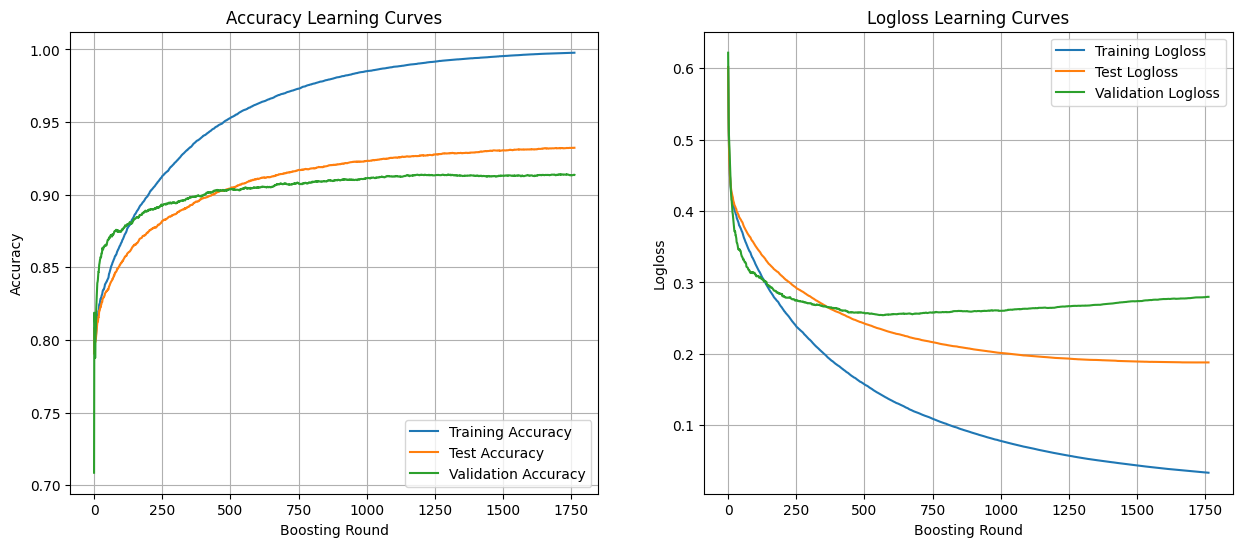

Validation Set Balanced Accuracy Score: 0.7428222905265749


In [24]:
# Try XGB enable category later
scale = len(y_train[y_train['label'] == 0])/len(y_train[y_train['label'] == 1])

clf_xgb = xgb.XGBClassifier(
    objective = 'binary:logistic',
    n_estimators =10000,
    reg_alpha=1,
    scale_pos_weight=scale)

# Fit the model
clf_xgb.fit(
    X_train, y_train,
    eval_set=[(X_train,y_train),(X_val,y_val),(X_test, y_test)],
    eval_metric=['error','logloss'],  # Use 'logloss' or other built-in metrics
    early_stopping_rounds=30,
    verbose=True,
)

# Get the evaluation results
results = clf_xgb.evals_result()

# Get the number of boosting rounds
n_boosting_rounds = len(results['validation_0']['logloss'])

# Plot learning curves
epochs = range(0, n_boosting_rounds)
train_logloss = results['validation_0']['logloss']
val_logloss = results['validation_1']['logloss']
test_logloss = results['validation_2']['logloss']


# Plot learning curves
epochs = range(0, n_boosting_rounds)
train_accuracy = [1 - x for x in results['validation_0']['error']]  # Convert error to accuracy
val_accuracy = [1 - x for x in results['validation_1']['error']]  # Convert error to accuracy
test_accuracy = [1 - x for x in results['validation_2']['error']]  # Convert error to accuracy
train_logloss = results['validation_0']['logloss']
val_logloss = results['validation_1']['logloss']
test_logloss = results['validation_2']['logloss']

# Plot accuracy
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, test_accuracy, label='Test Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Boosting Round')
plt.ylabel('Accuracy')
plt.title('Accuracy Learning Curves')
plt.legend()
plt.grid(True)

# Plot logloss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_logloss, label='Training Logloss')
plt.plot(epochs, test_logloss, label='Test Logloss')
plt.plot(epochs, val_logloss, label='Validation Logloss')
plt.xlabel('Boosting Round')
plt.ylabel('Logloss')
plt.title('Logloss Learning Curves')
plt.legend()
plt.grid(True)

plt.show()

# Evaluate final model on the test set
y_pred = clf_xgb.predict(X_val)
test_score = metrics.balanced_accuracy_score(y_val, y_pred)
print(f"Validation Set Balanced Accuracy Score: {test_score}")


Text(0.5, 0, 'Predictor')

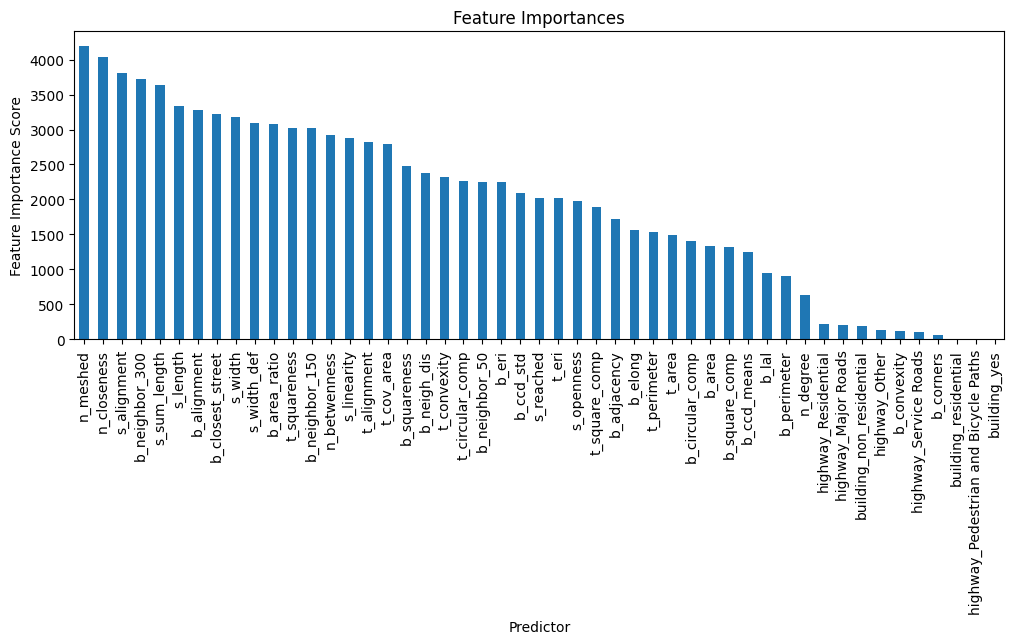

In [26]:
pd.Series(clf_xgb.get_booster().get_fscore()).sort_values(ascending=False).plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.xlabel('Predictor')

Train ---


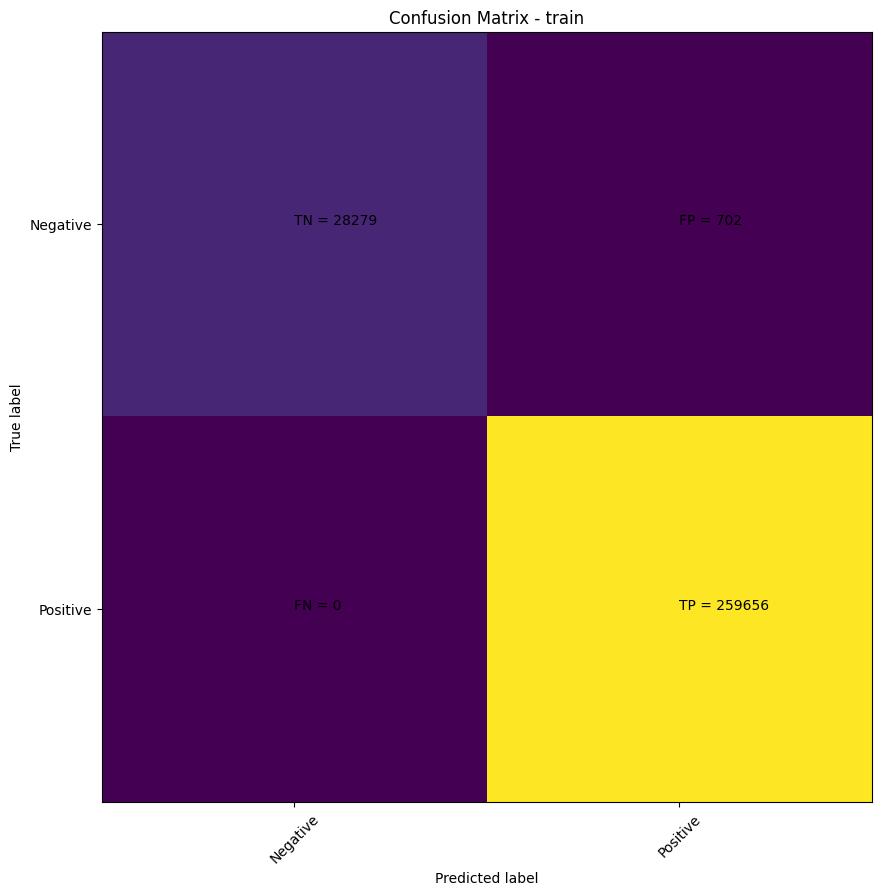

Balanced accuracy score : 0.998651856290185
Accuracy score : 0.9975678793779037
f1-score : 0.9986500363451754
Specificity : 0.9757772333597875 

Test ---


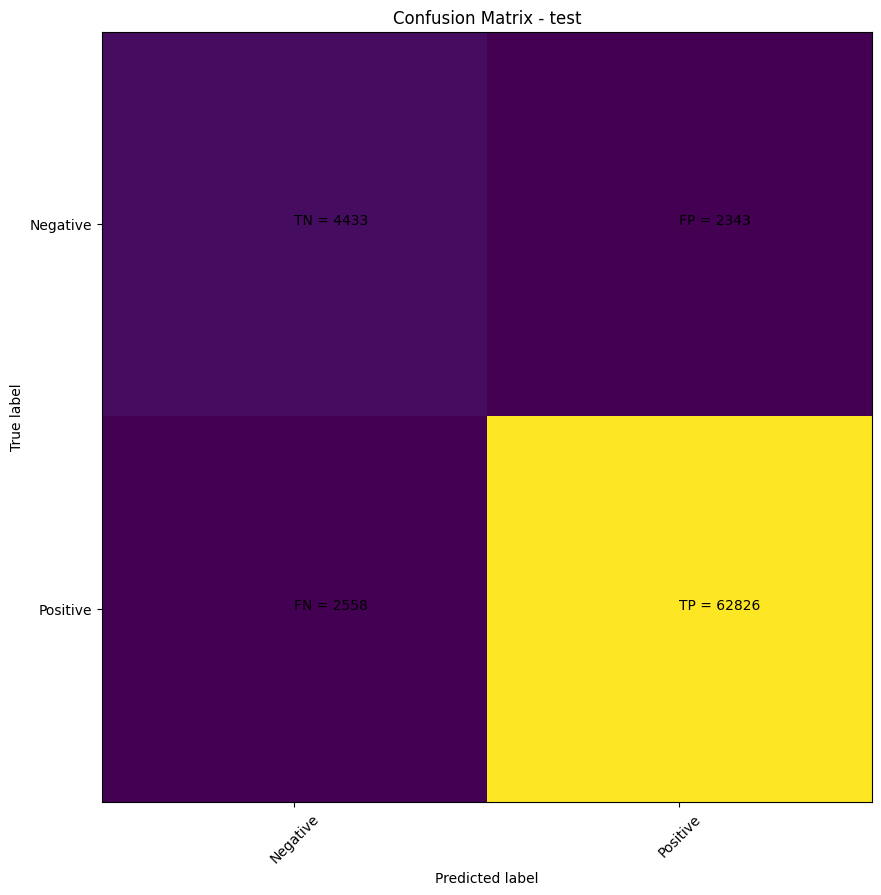

Balanced accuracy score : 0.7990741550485073
Accuracy score : 0.9320814855875832
f1-score : 0.9624596907003286
Specificity : 0.6542207792207793 

Validation ---


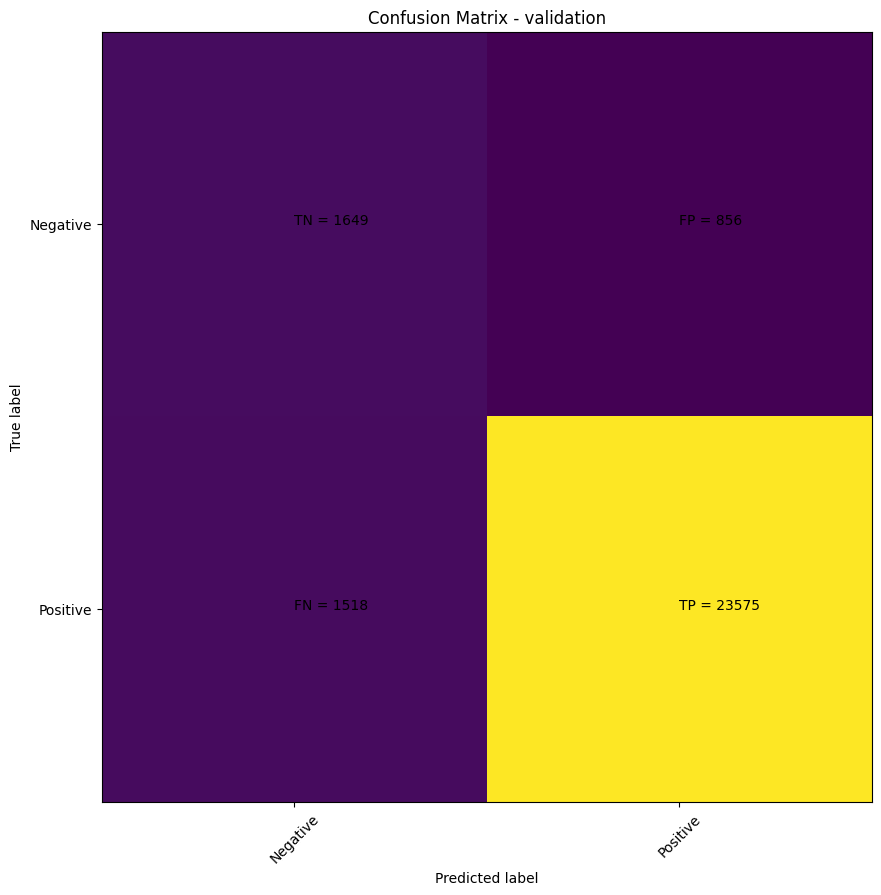

Balanced accuracy score : 0.7428222905265749
Accuracy score : 0.9139792738604247
f1_score : 0.9520636459090542
Specificity : 0.6582834331337325


In [27]:
# Calculate the score
y_train_pred = clf_xgb.predict(X_train)
y_test_pred = clf_xgb.predict(X_test)
y_val_pred = clf_xgb.predict(X_val)

print('Train ---')
TN, FP, FN, TP = confusio_matrix(y_train_pred, y_train, 'train')
print('Balanced accuracy score :', metrics.balanced_accuracy_score(y_train, y_train_pred))
print('Accuracy score :', metrics.accuracy_score(y_train,y_train_pred))
print('f1-score :', metrics.f1_score(y_train,y_train_pred))
print('Specificity :', TN/(FP+TN), '\n')

print('Test ---')
TN, FP, FN, TP = confusio_matrix(y_test_pred, y_test, 'test')
print('Balanced accuracy score :', metrics.balanced_accuracy_score(y_test, y_test_pred))
print('Accuracy score :', metrics.accuracy_score(y_test,y_test_pred))
print('f1-score :', metrics.f1_score(y_test,y_test_pred))
print('Specificity :', TN/(FP+TN), '\n')

print('Validation ---')
TN, FP, FN, TP = confusio_matrix(y_val_pred, y_val, 'validation')
print('Balanced accuracy score :', metrics.balanced_accuracy_score(y_val, y_val_pred))
print('Accuracy score :', metrics.accuracy_score(y_val,y_val_pred))
print('f1_score :', metrics.f1_score(y_val, y_val_pred))
print('Specificity :', TN/(FP+TN))

Overall not bad haha, but lets tune the hyperparameters for better performance

In [ ]:
y_predict = clf_xgb.predict(X)
df_encoded['predicted'] = y_predict

In [62]:
y_predict = clf_xgb.predict(X_val)
validation_df_encoded['pred'] = y_predict
data = validation_df_encoded[['bID_kec','pred']]
data.to_csv('hasil_validation.csv')

In [63]:
data_pred = df_encoded[['bID_kec','label','predicted']]
data_pred

,bID_kec,label,predicted
0,CIL1,0,0
1,CIL2,0,0
2,CIL3,0,0
3,CIL4,0,0
4,CIL5,0,0
...,...,...,...
31449,TEB31486,0,0
31450,TEB31487,0,0
31451,TEB31488,1,1
31452,TEB31489,1,1


In [64]:
data_pred.to_csv('hasil.csv')

# 2. Hyperparameters Tuning

In [17]:
# We use Grid Search CV

param_test1 = {
'max_depth':[8,9,10],
'learning_rate':[0.15],
'gamma':[0.05],
'reg_lambda':[0.3],
'scale_pos_weight':[0.1],
'min_child_weight':[0]
}

check_params = GridSearchCV(
    estimator = xgb.XGBClassifier(
        objective='binary:logistic',
        subsample=0.9,
        colsample_bytree=0.5
    ),
    param_grid=param_test1,
    scoring='logloss',
    verbose=2,
    cv=3
)

check_params.fit(
    X_train,
    y_train,
    early_stopping_rounds=10,
    eval_metric='logloss',
    eval_set=[(X_test,y_test)],
    verbose=False
)

InvalidParameterError: The 'scoring' parameter of GridSearchCV must be a str among {'r2', 'neg_brier_score', 'roc_auc_ovr', 'roc_auc_ovo_weighted', 'matthews_corrcoef', 'precision', 'homogeneity_score', 'max_error', 'jaccard_samples', 'mutual_info_score', 'neg_root_mean_squared_log_error', 'precision_samples', 'f1_micro', 'recall_weighted', 'explained_variance', 'neg_mean_poisson_deviance', 'jaccard_weighted', 'neg_median_absolute_error', 'roc_auc_ovo', 'neg_mean_squared_error', 'neg_mean_absolute_error', 'recall', 'jaccard', 'jaccard_micro', 'neg_negative_likelihood_ratio', 'neg_log_loss', 'adjusted_rand_score', 'balanced_accuracy', 'precision_weighted', 'f1_samples', 'rand_score', 'neg_mean_gamma_deviance', 'normalized_mutual_info_score', 'roc_auc', 'f1_macro', 'top_k_accuracy', 'jaccard_macro', 'neg_mean_absolute_percentage_error', 'fowlkes_mallows_score', 'precision_macro', 'average_precision', 'neg_root_mean_squared_error', 'f1', 'precision_micro', 'recall_macro', 'roc_auc_ovr_weighted', 'v_measure_score', 'completeness_score', 'positive_likelihood_ratio', 'recall_micro', 'adjusted_mutual_info_score', 'neg_mean_squared_log_error', 'f1_weighted', 'accuracy', 'recall_samples'}, a callable, an instance of 'list', an instance of 'tuple', an instance of 'dict' or None. Got 'logloss' instead.

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Integer, Real

search_space = {
    'clf__max_depth': Integer(2,8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}

opt = BayesSearchCV(xgb.XGBClassifier(objective = 'binary:logistic',n_estimators =10000,scale_pos_weight=scale), search_space, scoring='neg_log_loss' ,cv=3, n_iter=20,n_jobs=-1)
opt.fit(
    X_train,
    y_train,
    early_stopping_rounds=10,
    eval_metric='logloss',
    eval_set=[(X_test,y_test)],
    verbose=False
)

In [ ]:
opt.best_params_

In [ ]:
clf_xgb = xgb.XGBClassifier(
    objective = 'binary:logistic',
    n_estimators =  10000,
    scale_pos_weight=scale,
    eta=0.03,
    gamma=1,
    max_depth=5,
    min_child_weight=1,
    reg_alpha=0.5,
    reg_lambda=1,
    )

# Fit the model
clf_xgb.fit(
    X_train, y_train,
    eval_set=[(X_train,y_train), (X_val,y_val),(X_test, y_test)],
    eval_metric=['error','logloss'],  
    early_stopping_rounds=50,
    verbose=True,
)

# Get the evaluation results
results = clf_xgb.evals_result()

# Get the number of boosting rounds
n_boosting_rounds = len(results['validation_0']['logloss'])

# Plot learning curves
epochs = range(0, n_boosting_rounds)
train_accuracy = [1 - x for x in results['validation_0']['error']]  # Convert error to accuracy
val_accuracy = [1 - x for x in results['validation_1']['error']]  # Convert error to accuracy
test_accuracy = [1 - x for x in results['validation_2']['error']]  # Convert error to accuracy
train_logloss = results['validation_0']['logloss']
val_logloss = results['validation_1']['logloss']
test_logloss = results['validation_2']['logloss']

# Plot accuracy
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, test_accuracy, label='Test Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Boosting Round')
plt.ylabel('Accuracy')
plt.title('Accuracy Learning Curves')
plt.legend()
plt.grid(True)

# Plot logloss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_logloss, label='Training Logloss')
plt.plot(epochs, test_logloss, label='Test Logloss')
plt.plot(epochs, val_logloss, label='Validation Logloss')
plt.xlabel('Boosting Round')
plt.ylabel('Logloss')
plt.title('Logloss Learning Curves')
plt.legend()
plt.grid(True)

plt.show()

# Evaluate final model on the test set
y_pred = clf_xgb.predict(X_val)
test_score = metrics.balanced_accuracy_score(y_val, y_pred)
print(f"Validation Set Balanced Accuracy Score: {test_score}")

In [ ]:
# Calculate the score
y_train_pred = clf_xgb.predict(X_train)
y_test_pred = clf_xgb.predict(X_test)
y_val_pred = clf_xgb.predict(X_val)

print('Train ---')
TN, FP, FN, TP = confusio_matrix(y_train_pred, y_train, 'train')
print('Balanced accuracy score :', metrics.balanced_accuracy_score(y_train, y_train_pred))
print('Accuracy score :', metrics.accuracy_score(y_train,y_train_pred))
print('f1-score :', metrics.f1_score(y_train,y_train_pred))
print('Specificity :', TN/(FP+TN), '\n')

print('Test ---')
TN, FP, FN, TP = confusio_matrix(y_test_pred, y_test, 'test')
print('Balanced accuracy score :', metrics.balanced_accuracy_score(y_test, y_test_pred))
print('Accuracy score :', metrics.accuracy_score(y_test,y_test_pred))
print('f1-score :', metrics.f1_score(y_test,y_test_pred))
print('Specificity :', TN/(FP+TN), '\n')

print('Validation ---')
TN, FP, FN, TP = confusio_matrix(y_val_pred, y_val, 'validation')
print('Balanced accuracy score :', metrics.balanced_accuracy_score(y_val, y_val_pred))
print('Accuracy score :', metrics.accuracy_score(y_val,y_val_pred))
print('f1_score :', metrics.f1_score(y_val, y_val_pred))
print('Specificity :', TN/(FP+TN))

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Define parameter grid
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Create the model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10000)

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='balanced_accuracy', cv=3, verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train, early_stopping_rounds=5, eval_metric='logloss', eval_set=[(X_test, y_test)], verbose=True)

# Best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Train with best parameters
best_xgb = grid_search.best_estimator_

# Plot learning curves
results = best_xgb.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

# Evaluate final model
y_pred = best_xgb.predict(X_test)
test_score = balanced_accuracy_score(y_test, y_pred)
print(f"Test Set Balanced Accuracy Score: {test_score}")
